<a href="https://colab.research.google.com/github/catebarry/explainable-techniques/blob/main/explainable_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 2: Explainable Techniques I - ML Court
### Catie Barry

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/xai-assignments/blob/dev/templates/template.ipynb)

# Description

In this project, we are investigating a real-world AI decision and arguing either for or against its validity using explainable AI (XAI) techniques such as SHAP, LIME, Anchors, and ICE.

I'll be exploring Case 2: Breast Cancer Misclassification 🟥 Prosecution

**SOURCES:**

For information about the case and dataset:
https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/machine_learning_court.ipynb

For implementation of local explainable techniques (LIME, Anchors, SHAP, ICE): https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb

In [116]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "explainable-techniques" # Change to your repo name
git_path = 'https://github.com/catebarry/explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'explainable-techniques' already exists and is not an empty directory.
/content/explainable-techniques
explainable_techniques.ipynb  README.md


In [2]:
# installations
!pip install lime anchor-exp shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=48fb7af963423898ebdef6198a3ad9afbd22e2578c4e663d028c8a36a0f19ced
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
  Created wheel for anchor-exp: filename=anchor_exp-0.0.2.0-py3-none-any.whl size=433502 sha256=d6013905e235f238be176864ee5661285b360aa20848348f6a621ef7141ee916
  Stored in directory: /root/.cache/pip/wheels/9b/5f/6b/cac283c098eb5a7512f69953e7b5ced94b17e4f8591401b978
Successfully built lime anchor-exp


In [117]:
# imports
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Data
import numpy as np, random
import pandas as pd
import matplotlib.pyplot as plt

# XAI
import shap
import lime
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(1)

# 🩺 Case 2: Tumor Misclassification - Breast Cancer Dataset

🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model's output is now under scrutiny.

🟥 **Prosecution**

Use explanation tools to evaluate how the model arrived at this decision. Consider whether any key medical indicators might have been overlooked or minimized.

🟦 **Defense**

Defend the decision with reference to the model's logic and learned feature importance. Consider how this decision aligns with the broader data trends.

In [118]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



Looking at the metrics above, we can already see that the malignant tumors the model classifies are mostly correct (high precision of 98%), but the model doesn't catch all malignant cases (slightly lower recall of 93%).

In [119]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


# Local Explanations
Patient X received a incorrect benign classification of tumor, which was later classified as malignant. We want to investigate how the model made this decision and whether any key indicators were missed in making the decision.

We will start by using LIME, Anchors, and SHAP as local explanations of the model's output for this particular instance.

## LIME 🍋
Local interpretable model-agnostic explanations (LIME) are interpretable models that are used to explain individual predictions of black box ML models by highlighting which features were most important in coming to a decision [(Ribeiro et al., 2016).](https://arxiv.org/abs/1602.04938)

Taking an initial look, the dataset contains 30 features, all numerical. The classes are relatively balanced, with 357 benign and 212 malignant tumor cases represented.

In [120]:
print("Features:", list(X.columns))
print("Number of features:", len(X.columns))


Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Number of features: 30


In [121]:
df_bc["target"].value_counts()

,count
target,
1,357
0,212


In [122]:

# define feature + class names
feature_names = X.columns.tolist()
class_names = ['malignant', 'benign']  # 0=malignant, 1=benign

In [123]:
# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    class_names=class_names,
    feature_names=feature_names,
    kernel_width=kernel_width,
    mode='classification')

# Explain the prediction using LIME
exp = explainer.explain_instance(
    data_row=focus_instance_bc.iloc[0].values,
    predict_fn=model_bc.predict_proba,
    num_features=30)

# Show the explanation
exp.show_in_notebook()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Interpretation
Prediction probabilities are shown on the left. Patient X's tumor was predicted to be benign with 85% confidence and malignant with 15% confidence.

Features that contributed to the prediction of malignant are shown on the left in blue, and features that contributed to the prediction of benign are shown on the right in orange. The table on the right shows the actual value for each feature for the instance, and the feature is highlighted with its contribution to each of the binary outcomes.

From this information, we can see that the most influential factors in classifying this tumor as benign were 'worst texture' (patient's value of 20.86 <= 21.05 cutoff value) and 'mean texture' (patient's value of 15.79 <= 16.17 cutoff value). Other important factors for the benign decision included: worst concave points, area error, and symmetry error.

Malignant factors, including worst radius, worst compactness, and worst concavity, were also present but were outweighted by the features that contributed to the benign prediction.

NOTE: LIME samples taken around training data's mass center (not around instance of interest); there is no robust way to find best kernel width


➡️ **Takeaway:** worst texture, along with mean texture, were the most influential factors in the benign prediction

🟢 Benign drivers: worst texture, mean texture, worst concave points, area error, symmetry error

🔴 Malignant drivers: worst radius, worst compactness, worst concavity

#Anchors ⚓️
High-Precision Model-Agnostic Explanations are used to explain individual predictions by finding an if-then decision rule that sufficiently "anchors" the prediction [(Ribeiro et al., 2018).](https://ojs.aaai.org/index.php/AAAI/article/view/11491)

In [124]:
# Initialize Anchors explainer
explainer_anchor = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values)

# Explain the prediction using Anchors
exp_anchor = explainer_anchor.explain_instance(
    focus_instance_bc.iloc[0].values,
    #model_bc.predict,
    lambda x: model_bc.predict(pd.DataFrame(x, columns=feature_names)),
    threshold=0.80)

In [125]:
# Print the prediction, anchor rule, precision, and coverage
print("Prediction:", explainer_anchor.class_names[model_bc.predict(focus_instance_bc)[0]])
print("Anchor Rule:", " AND ".join(exp_anchor.names()))
print("Precision: %.2f" % exp_anchor.precision())
print("Coverage: %.2f" % exp_anchor.coverage())

Prediction: benign
Anchor Rule: mean texture <= 16.17 AND worst texture <= 21.05
Precision: 0.95
Coverage: 0.21


###Interpretation

The Anchors rule created for this particular instance that resulted in the benign prediction was: mean texture <= 16.17 AND worst texture <= 21.05.

The precision is 0.95, meaning that in 95% of sampled neighbors that satisfy this rule, the model predicted the same benign outcome. The coverage is 0.21, meaning that only 21% of the dataset satisfies this rule.

So while the rule is very precise, it applies to a relatively small subset of patients (NOTE: there is a trade-off between coverage and precision).

Anchors produced slightly different results between runs. However, in every case, 'worst texture <= 21.05' was part of the rule, meaning that this factor was very influential in the model's decision to output benign and it's possible that it made its decision by weighting this one factor heavily and in the process neglected other factors.

Here are some other rules generated from different runs:

- Anchor Rule: worst concavity <= 0.39 AND worst texture <= 21.05
Precision: 0.94
Coverage: 0.23

- Anchor Rule: mean compactness > 0.06 AND worst texture <= 21.05
Precision: 0.94
Coverage: 0.16

- Anchor Rule: smoothness error <= 0.01 AND worst texture <= 21.05
Precision: 0.94
Coverage: 0.13

- Anchor Rule: symmetry error > 0.02 AND worst texture <= 21.05
Precision: 0.95
Coverage: 0.18

➡️ **Takeaway:** Benign prediction is locked in if worst texture is below a certain threshold, revealing a potential bias that overweights worst texture and simplifies the medical reality

# SHAP 🎲
SHapley Additive exPlanations approximate Shapley Values, which tell us how to fairly distribute "payout" to players depending on their contribution to the total payout [(Lundberg & Lee, 2017).](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)


In [126]:
# Compute SHAP values

X_background = shap.utils.sample(X_train, 100, random_state=42) # Sample background distribution with 100 instances from training set
explainer = shap.TreeExplainer(model_bc, X_background) # Use TreeExplainer algorithm with background distribution
shap_values_exp = explainer(X_test) # Get explainer for X_test

/tmp/ipython-input-753089211.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)


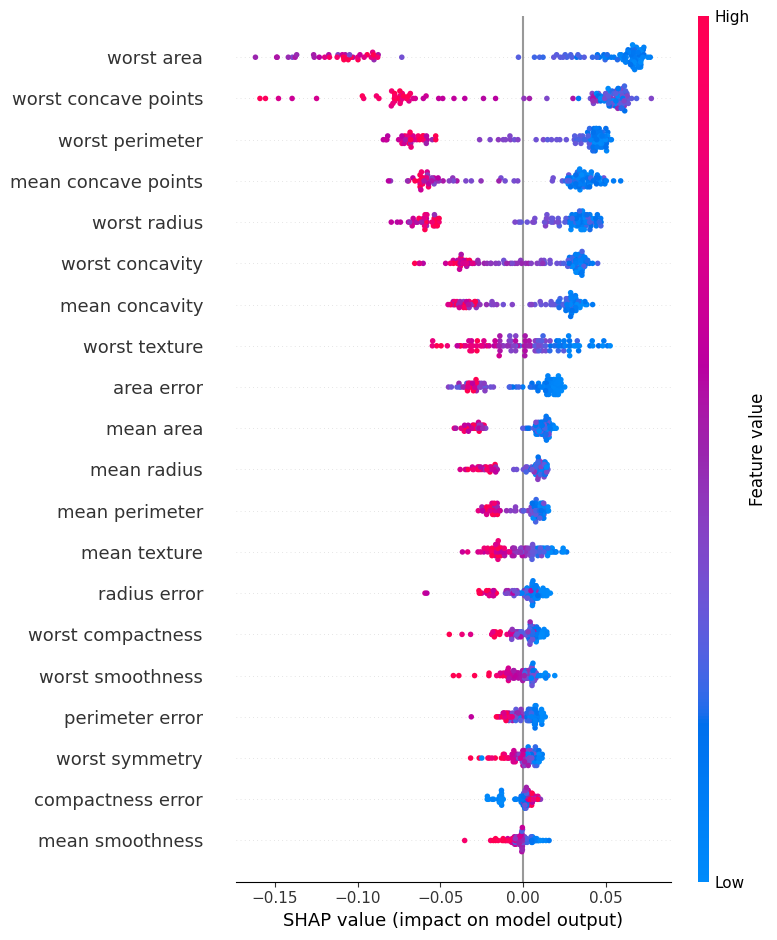

In [127]:
# Visualize SHAP with Summary Plot (how features contribute across the dataset)

shap.summary_plot(shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

This summary plot is a beeswarm plot, showing features on the y axis and SHAP values (the impact on the model output) on the x axis . A negative SHAP value indicates that the feature contributes to lowering the probability of the positive class or increasing the probability of the negative class (benign). Positive SHAP values mean that the feature contributes to increasing the probability of the positive class (malignant).

We can see that worst area, worst concave points, and worst perimeter had the highest SHAP values. There is also a distinct divide between those features predicting either malignant or benign, given the clustering of points either to the left or right of 0 (very few cases are ambiguous)--suggesting these features are very decisive and have higher explanatory power in the predictions.

However, features like worst texture and mean texture are more uniformly distributed with many points near 0 SHAP value--suggesting these are weaker, less decisive features. Sometimes it nudges the prediction towards benign or malignant, but often it has little effect. In Patient X's case, texture may have been over-relied on--it tipped the prediction to benign, but it's not a robust signal.

/tmp/ipython-input-3025023193.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names, plot_type="bar")


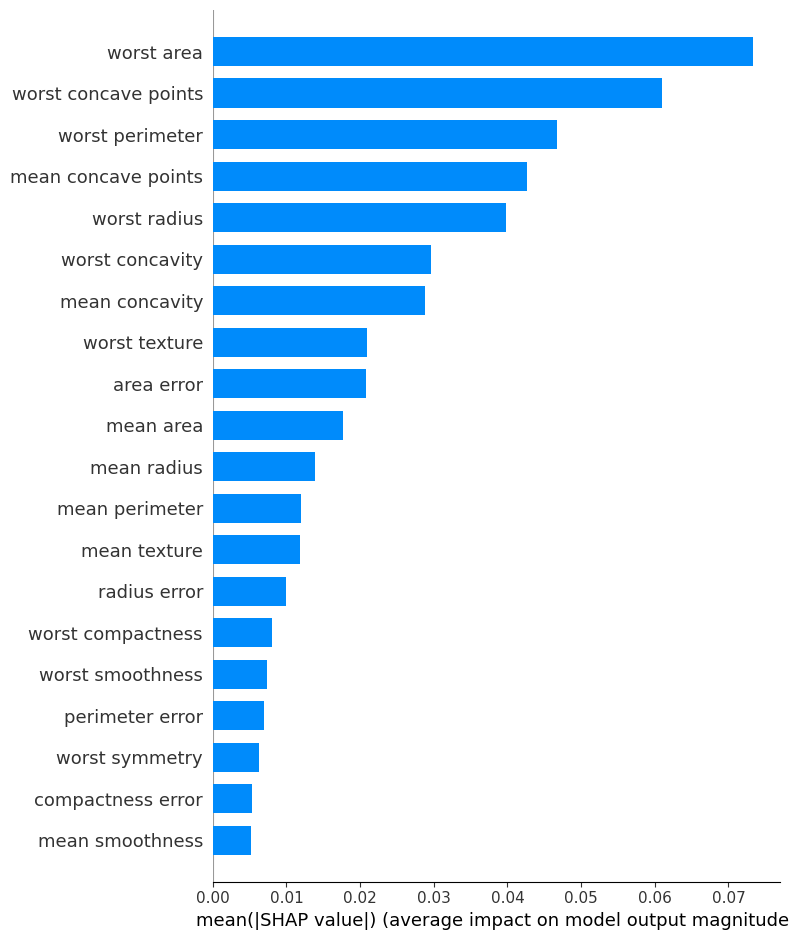

In [128]:
# bar chart
shap.summary_plot(shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names, plot_type="bar")

The bar chart lets us visualize the largest contributors to model output decisions. We can see that worst area, worst concave points, and worst perimeter contributed the most the model decisions.

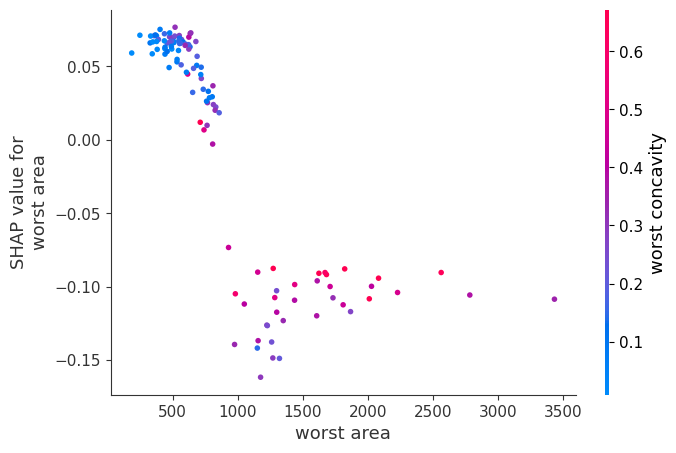

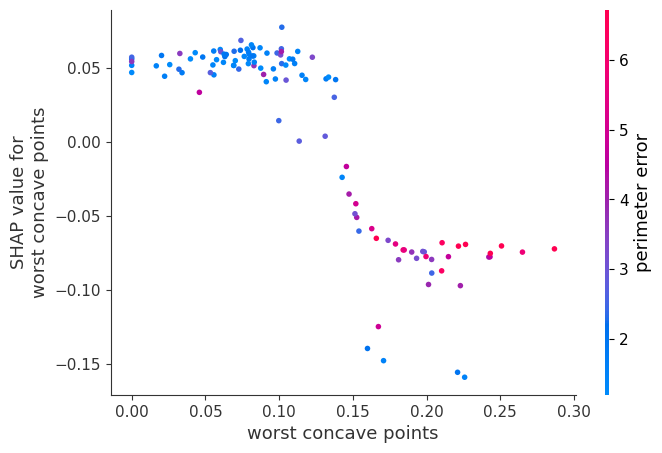

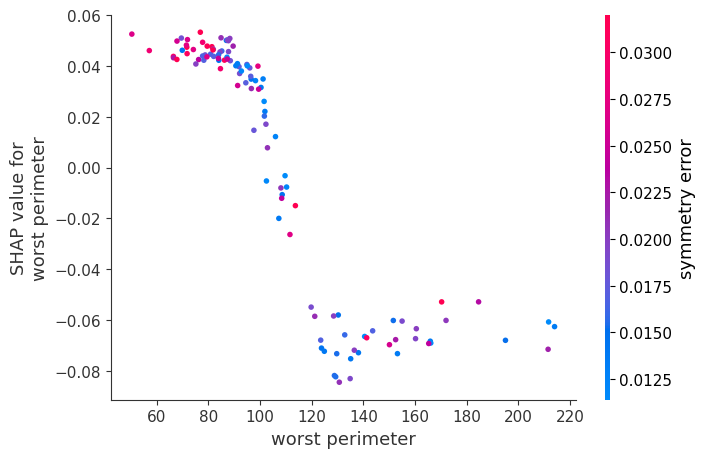

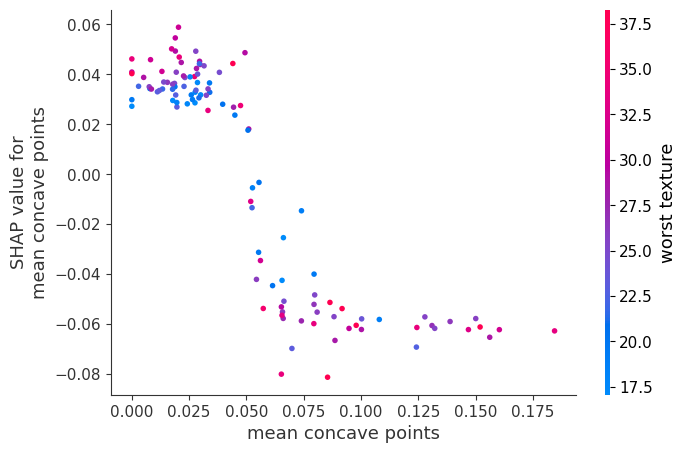

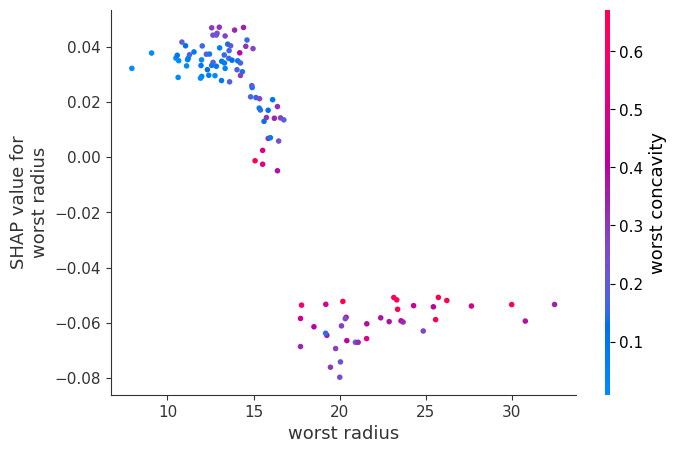

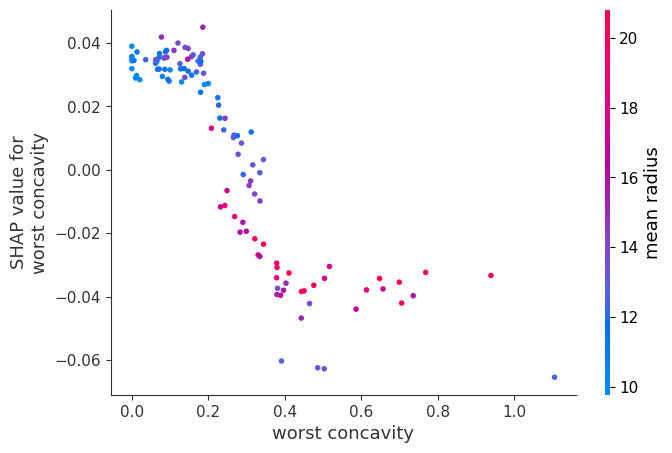

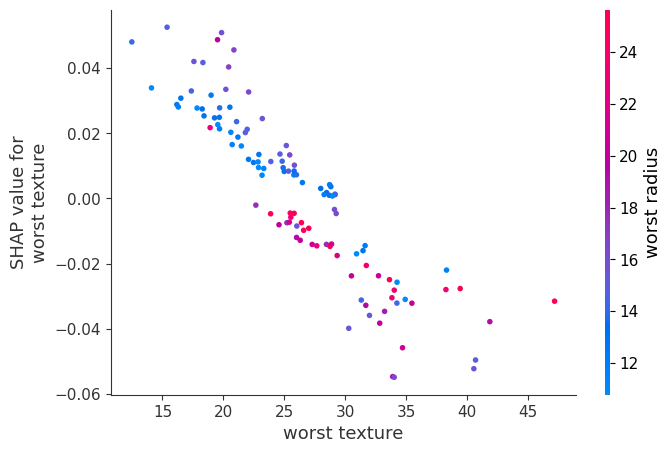

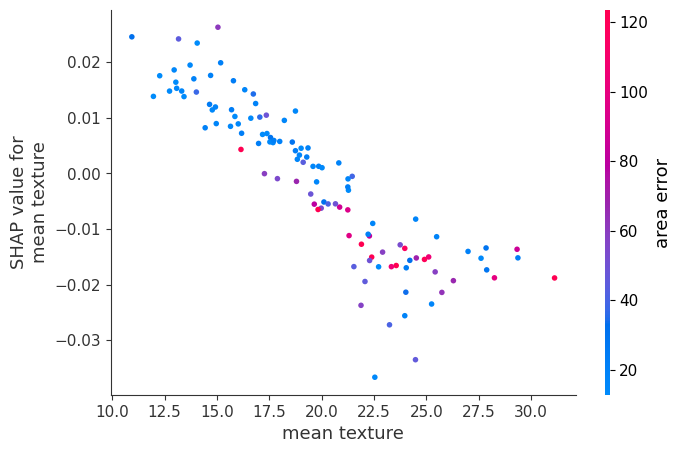

In [129]:
# Visualize SHAP with Dependence Plot
# features with highest abs val of shap values
# worst area has highest shap value, and did not contribute much to X's outcome
shap.dependence_plot('worst area', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# worst concave points has next highest shap value, and contributed to benign prediction in X
shap.dependence_plot('worst concave points', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# worst perimeter has next highest shap value, and didn't contribute much
shap.dependence_plot('worst perimeter', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# mean concave points has high shap value, and didn't contribute much
shap.dependence_plot('mean concave points', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# worst radius has high shap value, and contributed to malignant prediction in X
shap.dependence_plot('worst radius', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# worst concavity has high shap value, and contributed to malignant prediction in X
shap.dependence_plot('worst concavity', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)

# features that contributed most to patient x's benign prediction, but don't have partiuclarly high shap
shap.dependence_plot('worst texture', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)
shap.dependence_plot('mean texture', shap_values_exp.values[:, :, 1], X_test, feature_names=feature_names)




The SHAP dependence plots show how each feature influences predictions across the dataset. Features like worst area have a clear dividing line—smaller values push toward benign, larger toward malignant. In contrast, worst texture (Patient X's main driver) shows heavy overlap between benign and malignant cases, making it a weaker predictor.

For many of the strongest indicators (e.g., worst concave points, worst radius, worst concavity), Patient X's values fall in intermediate “tipping point" regions where small changes could flip the prediction. This instability reduced their impact/their effects were minimized, leaving the model to rely on weaker, less reliable features like texture—ultimately leading to the misclassification.


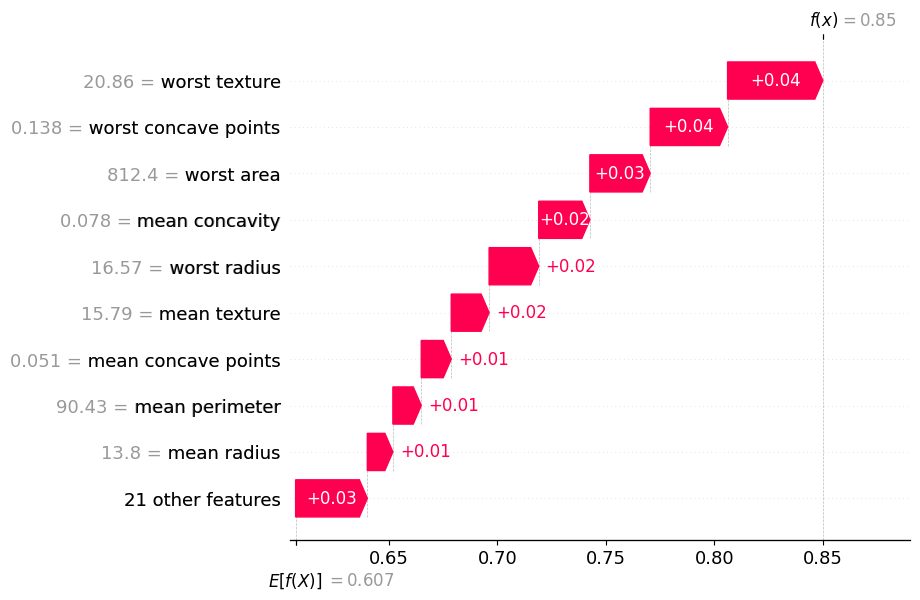

In [130]:
# Visualize an instance with a waterfall plot of the SHAP values

shap_values_focus = explainer(focus_instance_bc)
shap.plots.waterfall(shap_values_focus[0, :, 1])

The SHAP waterfall plot for Patient X shows that the strongest factors pushing toward a benign classification were worst texture and worst concave points (each contributing about +0.04). This plot again shows us the model's overreliance on weaker features like worst texture due to unclear signals from stronger feature predictors.

### Interpretation

The SHAP summary plot shows that features like worst area, worst concave points, and worst perimeter are typically decisive, strongly separating benign from malignant cases. In contrast, texture features (worst texture, mean texture) have more diffuse, near-zero contributions, indicating they are weaker predictors. However, for Patient X, texture features disproportionately drove the benign classification, while stronger malignant indicators such as concavity and radius were minimized.

➡️ **Takeaway:** Patient X's values fell in intermediate “tipping point” regions for many strong predictors, making the outcome highly unstable. A small shift in features like worst radius or worst concavity could have flipped the prediction to malignant, showing the model's reliance on weaker features led to a fragile and unreliable decision.

# ICE Plots 🧊
Individual Conditional Expectation (ICE) plots one line per instance that displays how the instance's prediction changes when a feature changes [(Goldstein et al., 2014).](https://arxiv.org/pdf/1309.6392)


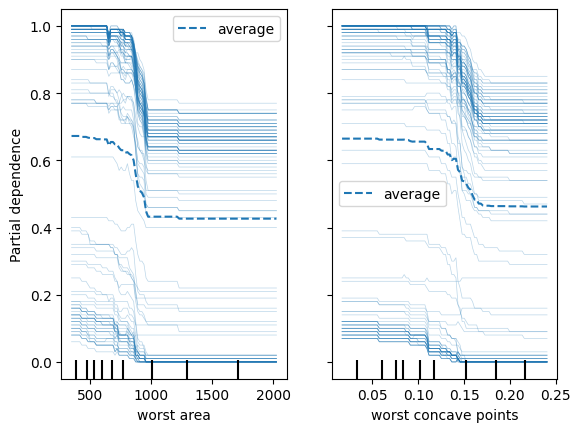

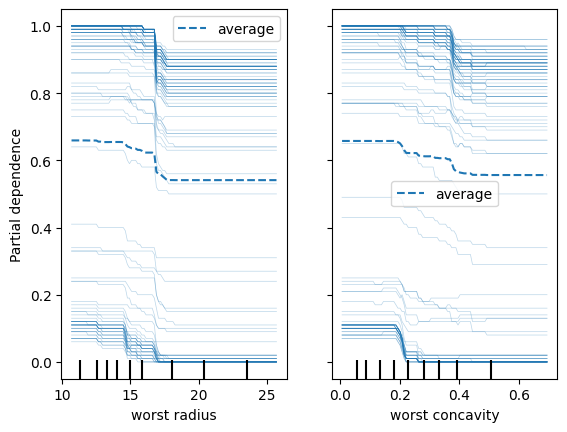

In [131]:
# Choose the feature of interest
features = ["worst area", "worst concave points"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model_bc, X_test, features, kind='both')

features = ["worst radius", "worst concavity"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model_bc, X_test, features, kind='both')

In [133]:
def plot_ice(instance, feature_name, model, X, class_index=1, num_points=50):
    """
    Plots an ICE curve for a single patient and a single feature.

    instance: pd.DataFrame (1 row, e.g. focus_instance_bc)
    feature_name: str (the feature to vary, e.g. "mean texture")
    model: trained sklearn model with predict_proba
    X: full dataset (needed to get min/max range for the feature)
    class_index: which probability to plot (1 = benign, 0 = malignant)
    num_points: how many steps in the grid
    """
    # Create feature grid
    feature_values = np.linspace(
        X[feature_name].min(),
        X[feature_name].max(),
        num_points
    )

    predictions = []
    for value in feature_values:
        modified_instance = instance.copy()
        modified_instance[feature_name] = value
        prob = model.predict_proba(modified_instance)[:, class_index][0]
        predictions.append(prob)

    # Plot ICE curve
    plt.figure(figsize=(8, 5))
    plt.plot(feature_values, predictions, marker='o')
    plt.xlabel(feature_name)
    plt.ylabel(f"Predicted probability of class {class_index}")
    plt.title(f"ICE Plot for Patient X – {feature_name}")
    plt.grid(True)
    plt.show()

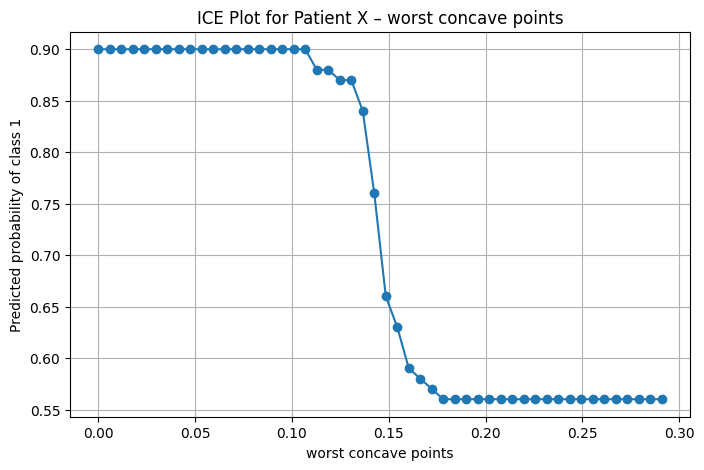

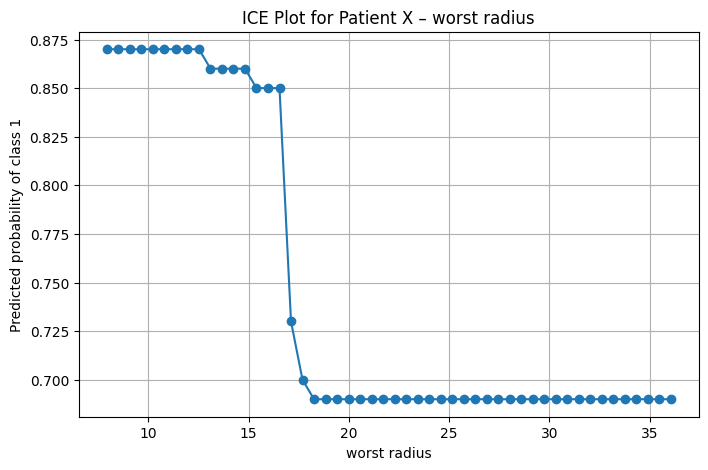

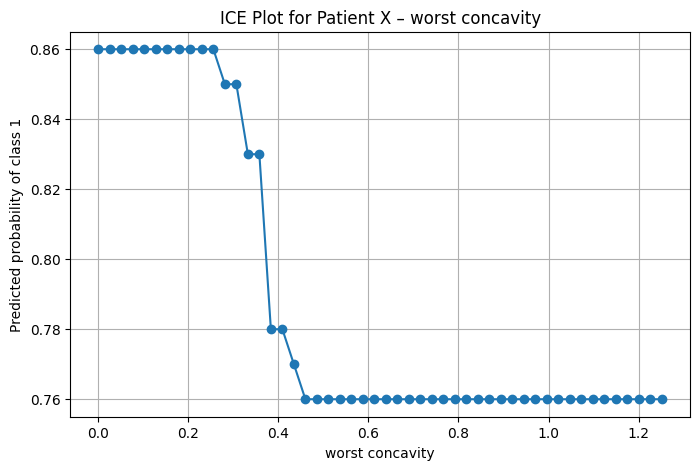

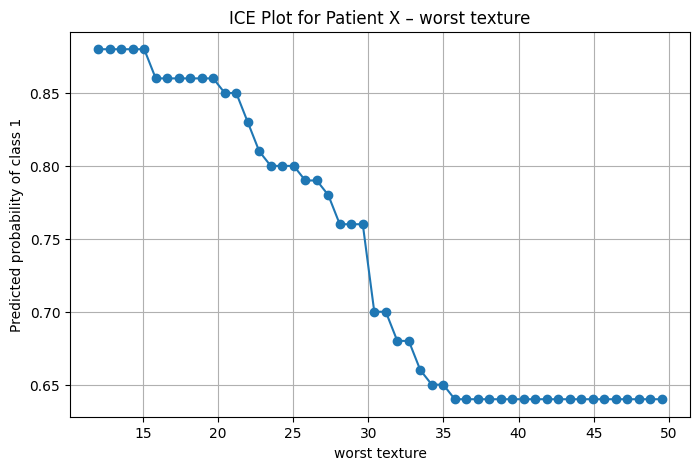

In [134]:
# For Patient X
plot_ice(focus_instance_bc, "worst concave points", model_bc, X)
plot_ice(focus_instance_bc, "worst radius", model_bc, X)
plot_ice(focus_instance_bc, "worst concavity", model_bc, X)
plot_ice(focus_instance_bc, "worst texture", model_bc, X)

### Interpretation
The ICE plots show how Patient X's prediction shifts when key features are varied. For worst concave points, worst radius, and worst concavity, for instance, Patient X lies on steep drop-offs where small changes could flip the classification from benign to malignant. This indicates that these strong predictors were unstable at Patient X's values, making the prediction fragile.

In contrast, worst texture—the feature that most drove the benign outcome—shows a smoother slope, meaning changes have less dramatic impact. While texture is a weaker predictor overall, the model relied heavily on it in this case, downplaying more decisive indicators that happened to fall in ambiguous ranges.

➡️ Takeaway: Many of Patient X's feature values lie in intermediate tipping points for strong indicators, so the model leaned on weaker, smoother features like texture, leading to a highly unstable and incorrect benign prediction.

# XAI Findings 💡


🔎 **Key questions:** How did the model arrive at its prediction? Were any key medical indicators overlooked or minimized?

Together, LIME, Anchors, SHAP, and ICE help us explain how the model came to its prediction and reveal a consistent story:
- The model overweighted certain features (especially worst texture), which drove Patient X's benign prediction. Yet texture is a weak predictor and should not be relied on as heavily--changes in its value do not significantly alter predictions.
- Patient X's values for stronger indicators (like worst concave points, worst radius, and worst concavity) fell in intermediate zones. In these ranges, small changes could flip the prediction between benign and malignant, showing the model's decision was fragile.
- Because these robust features were ambiguous for Patient X, the model instead leaned on weaker signals like texture. Even if the model could not confidently classify this borderline case as malignant, it should have at least recognized its reliance on unstable signals and flagged the prediction as uncertain.

➡️ **The model is not robust around real-world borderline cases, which is unacceptable in high stakes medical decisions. By minimizing decisive indicators that were ambiguous for Patient X and over-relying on weak features, it produced an unstable and incorrect benign prediction of a malignant tumor.**

